### Prepere environment

In [ ]:
!nvidia-smi

Mon May 10 11:30:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Mount google drive and prepare dataset

---
Dataset - just copy it ML folder on your google drive

https://drive.google.com/drive/folders/1rnlxC4xOKxDzdKRt5ZvX8RGRBveaIaXH?usp=sharing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = Path('drive/MyDrive/ML/Dataset')
DATASETS =['train',  'test']
train_folders = sorted(glob('drive/MyDrive/ML/Dataset/train/*'))
print(len(train_folders))

3


In [ ]:
class_names = ['book', 'box', 'cup']
class_indexes = [0, 1, 2]

In [ ]:
for i, cls_index in enumerate(class_indexes):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.jpg'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

book: 162
box: 135
cup: 300



### Data augmentation
https://pytorch.org/vision/stable/transforms.html
https://androidkt.com/pytorch-image-augmentation-using-transforms/ <- check more methods

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transformations = {'train': T.Compose([
  # T.Resize((300, 300)),
  # T.FiveCrop((256, 256)), <-- to check
  T.RandomResizedCrop((256, 256)), #256
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize((256, 256)),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

### Data loader
https://pytorch.org/vision/stable/datasets.html#imagefolder

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [ ]:
image_datasets = {d: ImageFolder(f'{DATA_DIR}/{d}', transformations[d]) for d in DATASETS}

data_loaders = {d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 130, 'train': 597}

### Creating the pre-trained ResNet model


In [ ]:
def create_model(n_classes):
  model = models.densenet169(pretrained=True)
  #Uncomment if you use ResNet model. It specify how many featurers and classes we use
  #For densenet it does not work, check gow to do it?
  # n_features = model.fc.in_features    
  # model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


### Training


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, max_n_epochs=30, max_loss=0.001):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #  <--- experiment with parameters  mom=00.9
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #  <--- experiment with parameters   step_size=4
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  min_train_loss = 1
  best_accuracy =0

  for epoch in range(max_n_epochs):

    print(f'Epoch {epoch + 1} / {max_n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn, optimizer, device, scheduler, dataset_sizes['train'])

    print(f'Train loss {train_loss} accuracy {train_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
   
    # torch.save(model.state_dict(), 'best_model_state.bin')

    #best accuracy   --->> seems better
    if best_accuracy<train_acc:
      torch.save(model.state_dict(), 'best_model_state.bin')  

    #smallest loss    

    # if min_train_loss>train_loss:
    #   torch.save(model.state_dict(), 'best_model_state.bin')      
    #   if abs(min_train_loss-train_loss)<max_loss:
    #     print("Desired change loss achived")
    #     break
    #   min_train_loss=train_loss

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, 60, 0.0001)

Epoch 1 / 60
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 1.3135466297591727 accuracy 0.6532663316582915
Epoch 2 / 60
----------
Train loss 0.6056312457223734 accuracy 0.7956448911222781
Epoch 3 / 60
----------
Train loss 0.5225153145411362 accuracy 0.7939698492462312
Epoch 4 / 60
----------
Train loss 0.38075489764412246 accuracy 0.8592964824120604
Epoch 5 / 60
----------
Train loss 0.46667676294532917 accuracy 0.8458961474036851
Epoch 6 / 60
----------
Train loss 0.45978032855239387 accuracy 0.8592964824120604
Epoch 7 / 60
----------
Train loss 0.36643700883879016 accuracy 0.8559463986599665
Epoch 8 / 60
----------
Train loss 0.2174755945087721 accuracy 0.931323283082077
Epoch 9 / 60
----------
Train loss 0.24169945889463026 accuracy 0.9212730318257957
Epoch 10 / 60
----------
Train loss 0.26839293602233133 accuracy 0.916247906197655
Epoch 11 / 60
----------
Train loss 0.22967176738505563 accuracy 0.9128978224455612
Epoch 12 / 60
----------
Train loss 0.1693811158106352 accuracy 0.9597989949748744
Epoch 13 / 60
----------
Train l

### Save the best model

In [ ]:
torch.save(base_model.state_dict(), 'model_state.bin')  
%cp -av model_state.bin drive/MyDrive/ML/Models

'model_state.bin' -> 'drive/MyDrive/ML/Models/model_state.bin'


### Training history

In [ ]:
def plot_training_history(history):
  fig, ax = plt.subplots(1, figsize=(18, 6))

  ax.plot(history['train_loss'], label='train loss')
  ax.plot(history['train_acc'], label='train accuracy')

  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_ylim([0, 1.05])
  ax.legend()
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  fig.suptitle('Training history')

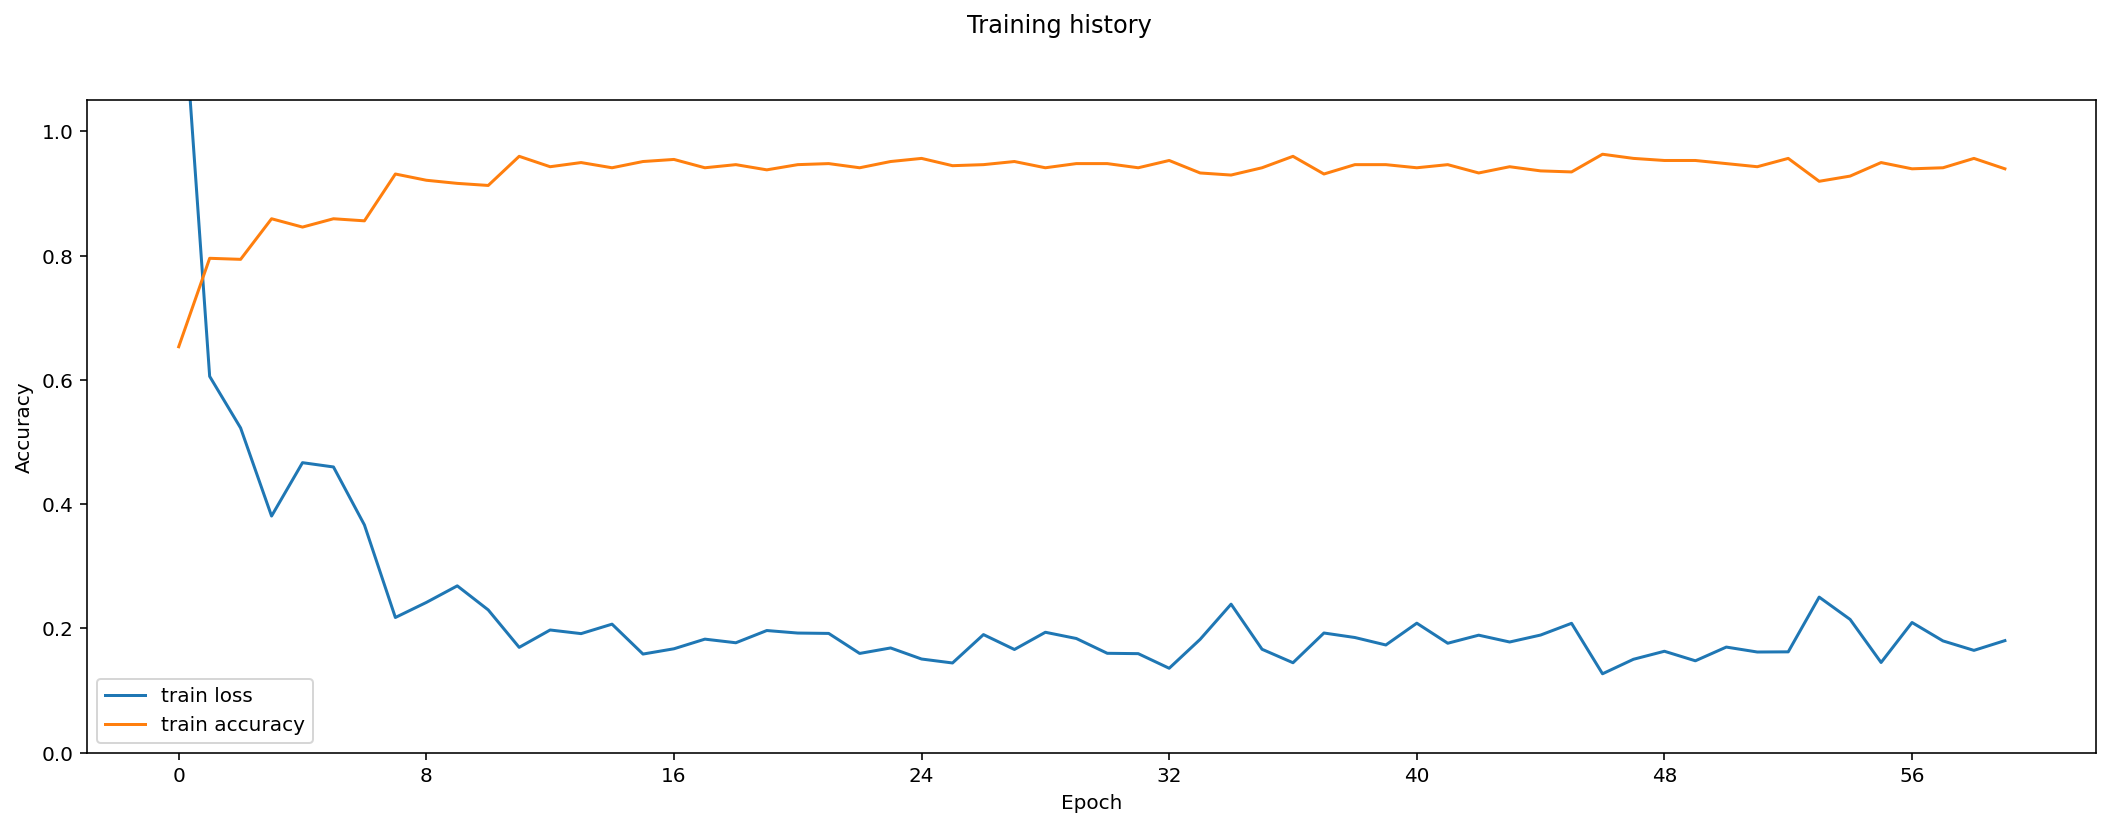

In [ ]:
plot_training_history(history)

###Evaluation

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        book       0.91      1.00      0.95        51
         box       1.00      0.87      0.93        39
         cup       0.93      0.93      0.93        40

    accuracy                           0.94       130
   macro avg       0.95      0.93      0.94       130
weighted avg       0.94      0.94      0.94       130



Saved models:
https://drive.google.com/drive/folders/1l-K32iWuY2PToAD2LQ5A278OLUTl6NLA?usp=sharing